In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
#sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams


In [2]:
print(sc.__version__)
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(mpl.__version__)


1.9.1
1.23.5
1.5.2
0.11.2
3.6.2


In [3]:
path = '/Users/busracagirici/Downloads/'
table_path = '/Users/busracagirici/Downloads/'
figure_path = '/Users/busracagirici/Downloads/'

adata = sc.read_h5ad(path+'GSE272840_ALO_viscRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 21044 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [5]:
filtered =adata[(adata.obs.high_quality=='True') & 
                (adata.obs.ID.isin(['24h_infected_DMSO', '24h_infected_RMC-113', '24h_uninfected_DMSO', '24h_uninfected_RMC-113'])) &
                (adata.obs.cell_type.isin(['AT2-like cells']))
               ]
filtered

View of AnnData object with n_obs × n_vars = 5708 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [6]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered.copy()


In [23]:
def plot_heatmap(markers_tmp, genes, title):
    fig, ax1 = plt.subplots(1,1,figsize=(0.8,len(genes)*0.3), gridspec_kw={'wspace':0.4})
    cbar_ax = fig.add_axes([.15, .07, .7, .03])

    #### 24h plots
    ind = [0,3,]
    tmp = markers_tmp.pivot_table(index='Gene', columns='label', values='lfc')
    tmp = tmp[tmp.columns[ind]].loc[genes]
    sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=ax1, 
            linewidths=1,
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change', 'orientation': 'horizontal'})
    pval = markers_tmp.pivot_table(index='Gene', columns='label', values='pval')
    pval = pval[pval.columns[ind]].loc[genes]
    first = True
    for i,col in enumerate(pval.columns):
        for j,gene in enumerate(pval.index):
            val = pval[col][gene]
            if val < 0.05:
                ax1.add_patch(
                    mpl.patches.Rectangle(
                     (i+0.07, j+0.07), 0.87, 0.87,
                    edgecolor='black',fill=False, lw=2
                    ) )
    ax1.set_xticklabels(['Infected vs uninfected (DMSO)', 'RMC-113 vs DMSO (uninfected)',],
                   fontsize=12, rotation=90)
    ax1.xaxis.tick_top()

    ax1.set_title('')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.text(1, 0.97, title, rotation=270, horizontalalignment='left',
     verticalalignment='top', transform=ax1.transAxes)


    fig.tight_layout()
    #fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
    #tmp.to_csv(f'{path}heatmap_4h.csv', sep='\t')
    #pval.to_csv(f'{path}heatmap_4h_pval.csv', sep='\t')
    plt.show()


In [7]:
ress = {}
for s in filtered.obs['ID'].cat.categories:
    print(s)
    #for ct in filtered.obs.cell_type.cat.categories:
    for ct in ['AT2-like cells']:
        if ct == 'NGFR-HOPX-CEACAM6+': continue
        adata_ct = filtered[filtered.obs.cell_type == ct].copy()
#        sc.pp.filter_genes(adata_ct, min_cells=3)
        sc.tl.rank_genes_groups(adata_ct, 'ID', method='wilcoxon', reference = s, key_added = "wilcoxon")
        ress[(ct, s)] = adata_ct.uns['wilcoxon']
        
        
markers = pd.DataFrame([])
for k,results in ress.items():
    ct = k[0]
    s = k[1]
    out = np.array([[0,0,0,0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['pvals'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group]),).astype('object'),
                                     np.array([s] * len(results['names'][group]),).astype('object'),
                                     np.array([ct] * len(results['names'][group]),).astype('object'),
                                    )).T
                        ))
    out = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'pval', 'lfc', 'Condition', 'reference', 'cell_type'])
    markers = pd.concat([markers, out], axis=0, join='outer')


markers['label'] = markers['Condition']+'_'+markers['reference']
labelmap = {'24h_infected_RMC-113_24h_infected_DMSO': '24h infected, RMC-113 vs DMSO',
           '24h_uninfected_RMC-113_24h_uninfected_DMSO': '24h uninfected, RMC-113 vs DMSO',
           '24h_infected_RMC-113_24h_uninfected_RMC-113': '24h RMC-113, infected vs uninfected',
           '24h_infected_DMSO_24h_uninfected_DMSO': '24h DMSO, infected vs uninfected',
#           '4h_infected_RMC-113_4h_infected_DMSO': '4h infected, RMC-113 vs DMSO',
#           '4h_uninfected_RMC-113_4h_uninfected_DMSO': '4h uninfected, RMC-113 vs DMSO',
#           '4h_infected_RMC-113_4h_uninfected_RMC-113': '4h RMC-113, infected vs uninfected',
#           '4h_infected_DMSO_4h_uninfected_DMSO': '4h DMSO, infected vs uninfected',
           
           }
markers['label'] = markers['label'].map(labelmap)
markers = markers[~markers['label'].isna()]
#markers

24h_infected_DMSO
24h_infected_RMC-113
24h_uninfected_DMSO
24h_uninfected_RMC-113


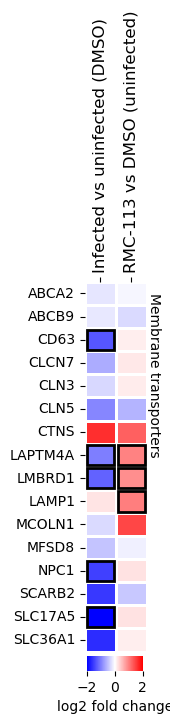

In [24]:
title = 'Membrane transporters'
genes = ['ABCA2', 'ABCB9', 'CD63', 'CLCN7', 'CLN3', 'CLN5', 'CTNS', 'LAPTM4A', 'LMBRD1', 'LAMP1', 'MCOLN1', 'MFSD8', 'NPC1', 'SCARB2', 'SLC17A5', 'SLC36A1',]
genes = [gene for gene in genes if gene in markers.Gene.to_list()]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]

plot_heatmap(markers_tmp, genes, title)

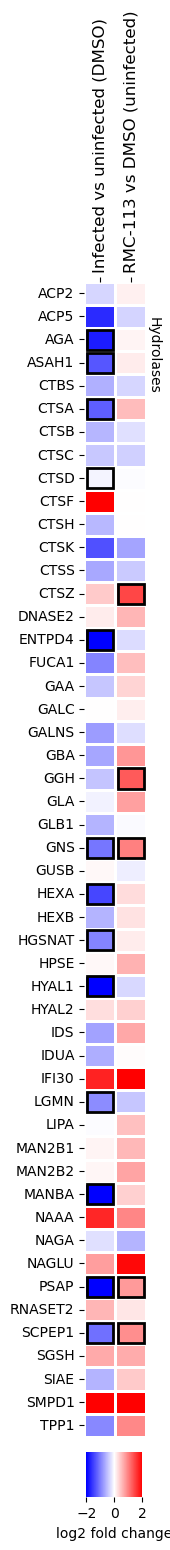

In [25]:
title = 'Hydrolases'
genes = ['ACP2', 'ACP5', 'AGA', #'ARSA', 'ARSB', 'ARSG', 
                'ASAH1', #'CPVL', 
                'CTBS', 'CTSA', 'CTSB', 'CTSC', 'CTSD', 'CTSF', 'CTSH', 'CTSK', 'CTSL1', 'CTSS', 'CTSZ', 'DNASE2', 'ENTPD4', 'FUCA1', 'GAA', 'GALC', 'GALNS', 'GBA', 'GGH', 'GLA', 'GLB1', 'GNS', 'GUSB', 'HEXA', 'HEXB', 'HGSNAT', 'HPSE', 'HYAL1', 'HYAL2', 'IDS', 'IDUA', 'IFI30', 'LGMN', 'LIPA', 'LYPLA3', 'MAN2B1', 'MAN2B2', 'MANBA', 'NAAA', 'NAGA', 'NAGLU', 
                #'NEU1', 'NEU4', 'P76', 'PLBD2', 'PPT1', 'PPT2', 
                'PSAP', 'RNASET2', 'SCPEP1', 'SGSH', 'SIAE', 'SMPD1', 'TMEM55B', 'TPP1']

genes = [gene for gene in genes if gene in markers.Gene.to_list()]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]

plot_heatmap(markers_tmp, genes, title)

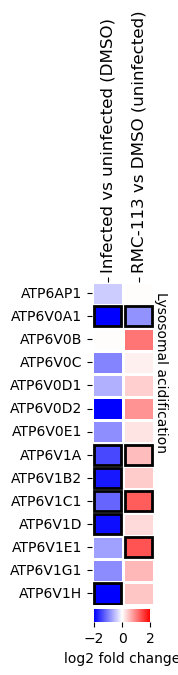

In [26]:
title = 'Lysosomal acidification'
genes = ['ATP6AP1', 'ATP6V0A1', 'ATP6V0B', 'ATP6V0C', 'ATP6V0D1', 'ATP6V0D2', 'ATP6V0E1', 'ATP6V1A', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1G1', 'ATP6V1H']

genes = [gene for gene in genes if gene in markers.Gene.to_list()]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]

plot_heatmap(markers_tmp, genes, title)

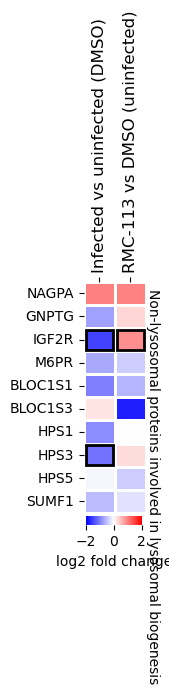

In [27]:
title = 'Non-lysosomal proteins involved in lysosomal biogenesis'
genes = ['NAGPA', 'GNPTG', 'IGF2R', 'M6PR', 'BLOC1S1', 'BLOC1S3', 'HPS1', 'HPS3', 'HPS5', 'SUMF1']

genes = [gene for gene in genes if gene in markers.Gene.to_list()]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]

plot_heatmap(markers_tmp, genes, title)

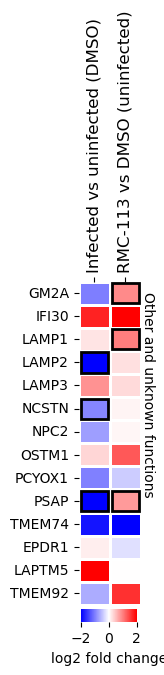

In [28]:
title = 'Other and unknown functions'
genes = ['GM2A', 'IFI30', 'LAMP1', 'LAMP2', 'LAMP3', #'MPO', 
                'NCSTN', 'NPC2', 'OSTM1', 'PCYOX1', 'PSAP', 'TMEM74', 'C2orf18', 'C7orf28A', 'EPDR1', 'LAPTM5', 'TMEM92']

genes = [gene for gene in genes if gene in markers.Gene.to_list()]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]

plot_heatmap(markers_tmp, genes, title)